In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps
import animate

# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams["font.family"] = "sans-serif"
# matplotlib.rcParams["font.family"] = "serif"
# matplotlib.rcParams['font.serif'] = "Times New Roman"

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-06-16_figures'
save = True

Names

In [4]:
name_catalog = '\emph{{Gaia}}-\emph{{unWISE}} Quasar Catalog'
abbrv_catalog = 'Quaia'

name_gpurer = "\emph{{Gaia}} DR3 Quasars `Purer' Sample"
abbrv_gpurer = "\emph{{Gaia}} DR3 `Purer'"

name_gall = "\emph{{Gaia}} DR3 Quasar Candidates"
abbrv_gall = "\emph{{Gaia}} DR3 Quasar Candidates"

name_sqall = "SDSS DR16Q Quasars"
abbrv_sqall = "SDSS DR16Q Quasars"

In [5]:
name_zgaia = "\emph{{Gaia}} redshift" 
abbrv_zgaia = "z_\mathrm{Gaia}"

name_zsdss = "\emph{{SDSS}} redshift" 
abbrv_zsdss = "z_\mathrm{SDSS}"

name_zspz = f"{abbrv_catalog} redshift" 
abbrv_zspz = f"z_\mathrm{{{abbrv_catalog}}}"

Plotting variables

In [6]:
cmap_anim = utils.shiftedColorMap(matplotlib.cm.plasma_r, start=0.2, midpoint=0.6, stop=1.0)
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0)
cmap_hist = utils.shiftedColorMap(matplotlib.cm.inferno_r, start=0.1, midpoint=0.55, stop=1.0)

color_gaia = 'purple'

Functions

In [7]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

Map settings

In [8]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [9]:
G_hi = 20.5
G_lo = 20.0

In [10]:
rng = np.random.default_rng(seed=42)

# Load datasets

### Gaia

In [11]:
fn_gall = '../data/gaia_candidates_plus.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [12]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [13]:
fn_gsup = '../data/gaia_candidates_superset.fits'
tab_gsup = utils.load_table(fn_gsup)
print(len(tab_gsup))

1518782


In [14]:
fn_gclean = '../data/gaia_candidates_clean.fits'
tab_gclean = utils.load_table(fn_gclean)
print(len(tab_gclean))

1414385


In [15]:
fn_gcatlo = f'../data/catalog_G{G_lo}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
print(len(tab_gcatlo))

755850


In [16]:
fn_gcathi = f'../data/catalog_G{G_hi}.fits'
tab_gcathi = utils.load_table(fn_gcathi)
print(len(tab_gcathi))

1295502


### SDSS

These are SDSS objects that have (any) Gaia source matches. There is unWISE data where available, but the below catalogs are not limited to unWISE matches.

In [17]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")

Number of SDSS quasars: 379698


In [18]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")

Number of SDSS stars: 683221


In [19]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")

Number of SDSS galaxies: 717059


SDSS quasars with zwarning=0; gaia and unWISE data where available

In [20]:
tab_sqall = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall_good.fits')
print(f"Number of all SDSS quasars: {len(tab_sqall)}")

Number of all SDSS quasars: 638083


### Other contaminants

In [21]:
tab_mcs = utils.load_table(f'../data/mcs_xgaia.fits')
print(f"Number of MC sources: {len(tab_mcs)}")

Number of MC sources: 1362378


### Combined

Only objects in superset (gaia qso candidates with unWISE data and QSOC redshifts and G lim)

In [22]:
fn_labeled_sup = '../data/labeled_superset.fits'
tab_labeled_sup = utils.load_table(fn_labeled_sup)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_sup)}")

Number of labeled Gaia quasar candidates for training/validation: 259641


# Figures

### Fractional matrix

In [23]:
tab_gqsoc = tab_gall[np.isfinite(tab_gall['redshift_qsoc'])]
print(len(tab_gqsoc))

6375063


In [24]:
tabs = [tab_gall, tab_gqsoc, tab_gpurer, tab_gsup, tab_gclean, tab_sqall]
tab_names = [abbrv_gall, 
             abbrv_gall+'\nwith redshift estimates', 
             abbrv_gpurer, 
             f'{abbrv_catalog} superset', 
             f'{abbrv_catalog} clean', 
             abbrv_sqall,
             'unWISE']
N_tabs = len(tabs)
N_rows = len(tab_names)

frac_matrix = np.empty((N_tabs, N_rows))
for i in range(N_tabs):
    for j in range(N_rows):
        #print(tab_names[i], tab_names[j])
        if tab_names[j]=='unWISE':
            i_iinj = np.isfinite(tabs[i]['mag_w1_vg']) & ~tabs[i].mask['mag_w1_vg'] & \
                     np.isfinite(tabs[i]['mag_w2_vg']) & ~tabs[i].mask['mag_w2_vg']
        else:
            i_iinj = np.isin(tabs[i]['source_id'], tabs[j]['source_id'])
        frac_matrix[i,j] = np.sum(i_iinj)/len(i_iinj)
        
frac_matrix = frac_matrix.T

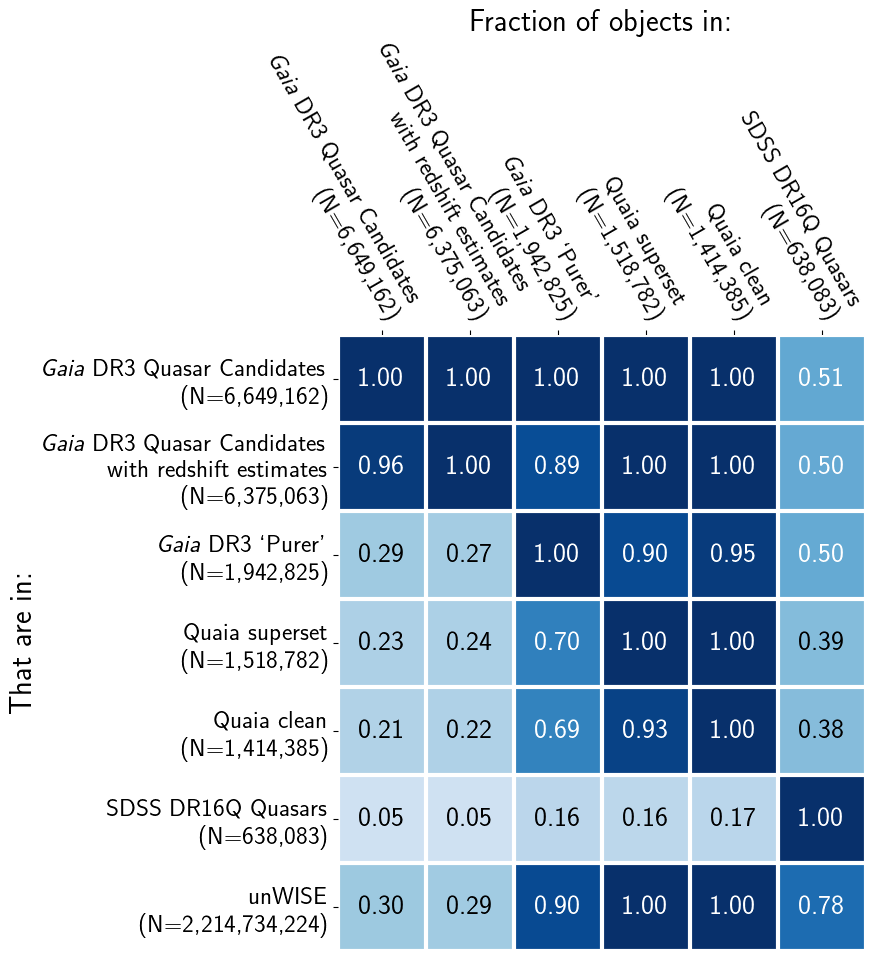

In [25]:
plt.figure(figsize=(8,8))
ax = plt.gca()
im = ax.imshow(frac_matrix, cmap=cmap_blues)

# Show all ticks and label them with the respective list entries
Ns = [len(tab) for tab in tabs]
N_wise = 2214734224  # via http://cdsarc.u-strasbg.fr/viz-bin/cat/II/363
Ns.append(N_wise)
labels_withN = [f'{tab_names[i]}\n(N={Ns[i]:,})' for i in range(N_rows)]
ax.set_xticks(np.arange(N_tabs), labels=labels_withN[:N_tabs])
ax.set_yticks(np.arange(N_rows), labels=labels_withN)
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",
             rotation_mode="anchor")

ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(frac_matrix.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(frac_matrix.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(N_rows):
    for j in range(N_tabs):
        color = 'w' if frac_matrix[i, j]>0.5 else 'k'
        text = ax.text(j, i, f"{frac_matrix[i, j]:.2f}",
                       ha="center", va="center", color=color, fontsize=20)
        
plt.title("Fraction of objects in:", fontsize=22)
plt.ylabel("That are in:", fontsize=22)

fn = f'{plot_dir}/frac_matrix.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Purer map

In [26]:
map_gpurer = get_ndens_map(tab_gpurer['ra'], tab_gpurer['dec'], NSIDE=NSIDE)

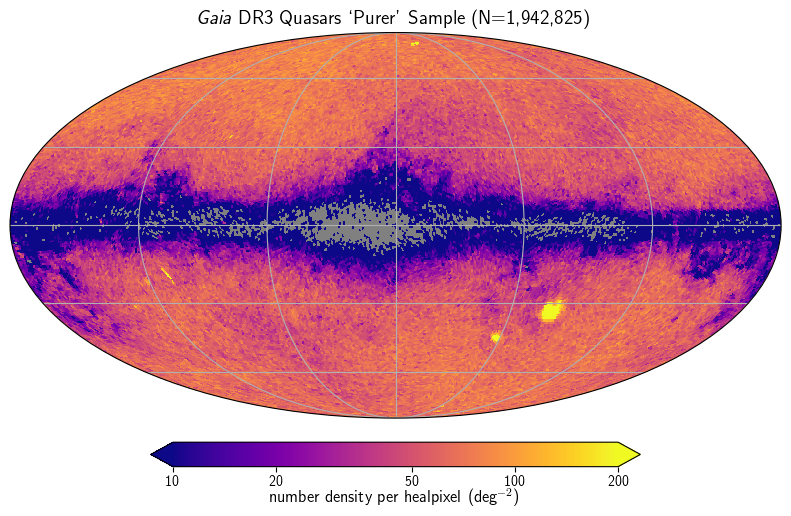

In [27]:
projview(map_gpurer, title=rf"{name_gpurer} (N={len(tab_gpurer):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=200, norm='log', graticule=True, cbar_ticks=[10, 20, 50, 100, 200]
        )

fn = f'{plot_dir}/gpurer_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Decontamination

Preliminaries

In [28]:
tabs_sall = [tab_squasars, tab_sstars, tab_sgals, tab_mcs]
colors_sall = ['blue', 'brown', 'orange', 'magenta']
labels_sall = ['SDSS Quasars', 'SDSS Stars', 'SDSS Galaxies', r'MCs $\times$ Gaia'+'\nQuasar Candidates']
#zorders_sall = [1,4,3,2]
zorders_sall = [1,3,4,2]

In [29]:
tab_pms = tab_gall.copy()
tab_pms.keep_columns(['source_id', 'pm'])

In [30]:
for i, tab in enumerate(tabs_sall):
    if 'pm' not in tab.columns:
        tabs_sall[i] = join(tab, tab_pms, keys='source_id', join_type='left')

In [31]:
tab_q = tab_labeled_sup[tab_labeled_sup['class']=='q']
tab_s = tab_labeled_sup[tab_labeled_sup['class']=='s']
tab_g = tab_labeled_sup[tab_labeled_sup['class']=='g']
tab_m = tab_labeled_sup[tab_labeled_sup['class']=='m']

tabs_ssup = [tab_s, tab_g, tab_m]
colors_ssup = ['brown', 'orange', 'magenta']
labels_ssup = [r'SDSS stars $\times$'+'\n'+f'{abbrv_catalog} superset', 
               r'SDSS galaxies $\times$'+'\n'+f'{abbrv_catalog} superset',
               r'LMC \& SMC stars $\times$'+'\n'+f'{abbrv_catalog} superset']
zorders_ssup = [3,2,1]

label_shist = rf'number of SDSS $\times$ {abbrv_catalog}'+'\nsuperset quasars'

In [32]:
label_ghist = rf'number of {abbrv_catalog}'+'\nsuperset quasars'

Proper motion vs G

In [33]:
def G_pm_plot(ax, fig, tabs_scatter=[], colors_scatter=[],
                 labels_scatter=[], zorders_scatter=[], N_subsample=None,
                 tab_hist=None, cmap_hist=None, label_hist=None, cmax_hist=None):

    ## histograms
    if tab_hist is not None:

        G = np.array(tab_hist['phot_g_mean_mag'])
        pm = np.array(tab_hist['pm'])
        h = ax.hist2d(G, pm, bins=(G_bins, pm_bins), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')
        
        fig.colorbar(h[3], ax=ax, label=label_hist)

    # scatters        
    patches = []
    for i in range(len(tabs_scatter)):
        tab = tabs_scatter[i]
        tab_plot = tab
        if N_subsample is not None and len(tab_plot)>N_subsample:
            i_subsample = rng.choice(np.arange(len(tab)), size=N_subsample, replace=False)
            tab_plot = tab_plot[i_subsample]

        ax.scatter(tab_plot['phot_g_mean_mag'], 
                    tab_plot['pm'],
                    color=colors_scatter[i], alpha=0.15, s=0.7, zorder=zorders_scatter[i])
        
        patches.append( mlines.Line2D([], [], ls='None', color=colors_scatter[i], 
                                      label=labels_scatter[i], marker='o'))

    # draw cut
    yy = utils._pm_G_line(G_bins)
    ax.plot(G_bins, yy, color='black')
    yy_max = np.full(len(yy), pm_bins[-1])
    ax.fill_between(G_bins, yy, yy_max, color='grey', zorder=0, alpha=0.15)

    # plot settings
    if len(patches)>0:
        ax.legend(handles=patches, loc='upper left', fontsize=16)

    ax.set_xlabel('$G$ magnitude')
    ax.set_ylabel(r'$\mu$, proper motion [mas/yr]')
    ax.set_yscale('log')

    ax.set_xlim(G_bins[0], G_bins[-1])
    ax.set_ylim(pm_bins[0], pm_bins[-1])

In [34]:
xlim = 5, 20.6
bin_width = 0.2
G_bins = np.arange(xlim[0], xlim[1]+bin_width, bin_width)
pm_bins = np.logspace(np.log10(0.001), np.log10(300))

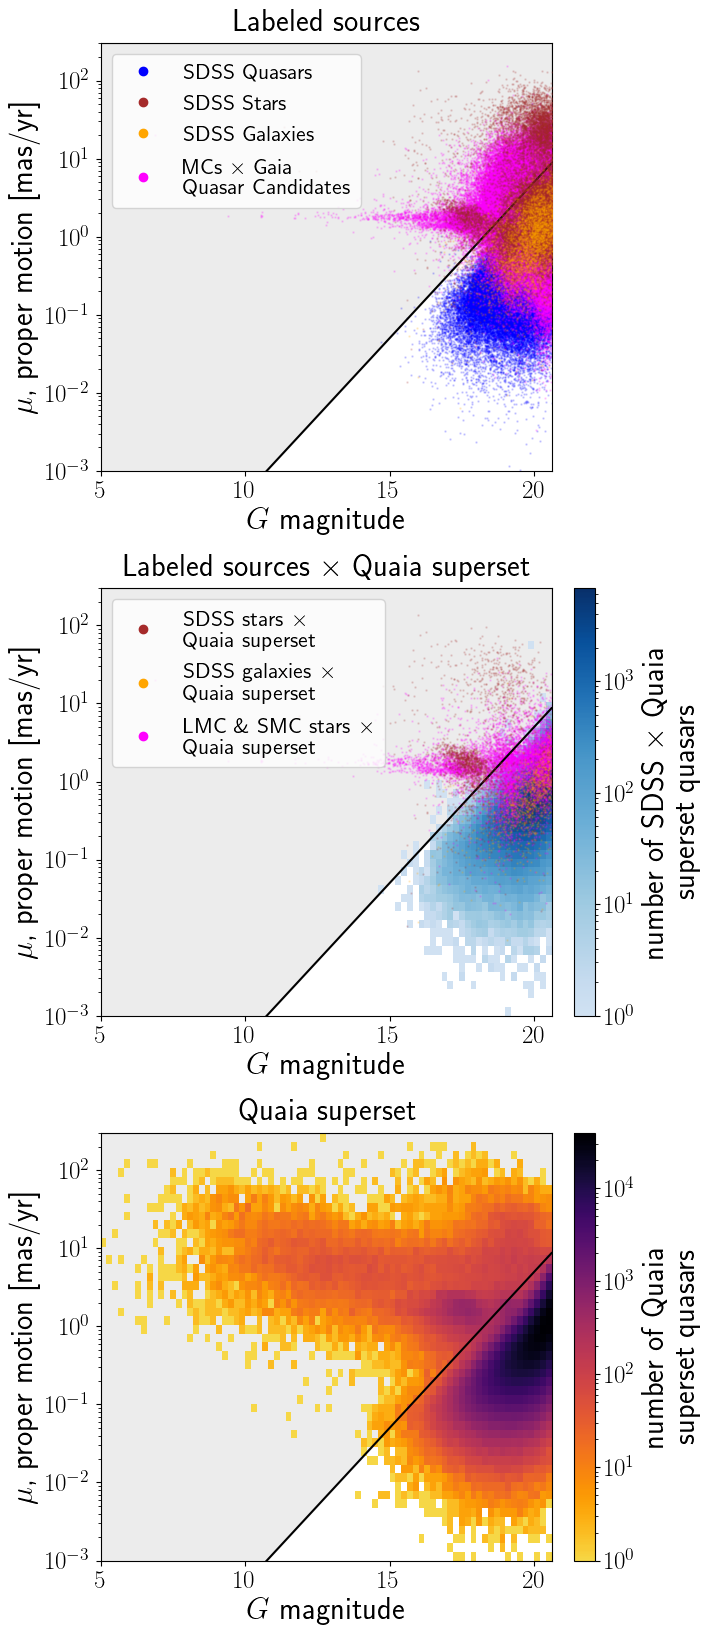

In [35]:
nrows = 3
fig, axarr = plt.subplots(nrows=nrows, ncols=1, figsize=(7,5.3*nrows), constrained_layout=True)
title_x = 0.46
fig.text(title_x, 1.01, "Labeled sources", fontsize=22, va="center", ha="center")
fig.text(title_x, 0.6675, rf"Labeled sources $\times$ {abbrv_catalog} superset", fontsize=22, va="center", ha="center")
fig.text(title_x, 0.325, abbrv_catalog+' superset', fontsize=22, va="center", ha="center")

G_pm_plot(axarr[0], fig, tabs_scatter=tabs_sall, colors_scatter=colors_sall, 
                     labels_scatter=labels_sall, zorders_scatter=zorders_sall)#, N_subsample=20000)
G_pm_plot(axarr[1], fig, tabs_scatter=tabs_ssup, colors_scatter=colors_ssup, 
             labels_scatter=labels_ssup, zorders_scatter=zorders_ssup,
             tab_hist=tab_q, cmap_hist=cmap_blues, label_hist=label_shist, cmax_hist=5e4)
G_pm_plot(axarr[2], fig,
             tab_hist=tab_gsup, cmap_hist=cmap_hist, label_hist=label_ghist, cmax_hist=2e5)

fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

fn = f'{plot_dir}/G_pm.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

Color cuts

In [36]:
def plot_color_cuts(ax, cuts, cut_names, x_color_name, y_color_name, xlim, ylim,
              x_orders=None, y_orders=None, zorder=100):

    i_x, i_y = None, None
    if x_color_name in cut_names:
        i_x = cut_names.index(x_color_name)
    if y_color_name in cut_names:
        i_y = cut_names.index(y_color_name)
    
    color = 'k'
    cuts_toplot = []
    x_orders_toplot = []
    y_orders_toplot = []
    for i, cut_full in enumerate(cuts): 
        if i_x is None and i_y is None:
            continue
            
        intercept = cut_full[cut_names.index('intercept')]
        cut = [cut_full[i_x], cut_full[i_y], intercept]

        if i_y is None:
            cut[1] = 0
        if i_x is None:
            cut[0] = 0
        if cut[0]==0 and cut[1]==0:
            continue
            
        cuts_toplot.append(cut)
        x_orders_toplot.append(x_orders[i])
        y_orders_toplot.append(y_orders[i])
          
    xlims = [list(xlim) for _ in range(len(cuts_toplot))]
    ylims = [list(ylim) for _ in range(len(cuts_toplot))]

    # this is ugly but i think need some user input to determine order??
    for ix in range(len(x_orders_toplot)-1):
        i, j = x_orders_toplot.index(ix), x_orders_toplot.index(ix+1)
        cut_0, cut_1 = cuts_toplot[i], cuts_toplot[j]
        x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
        xlims[i][1] = x_eq
        xlims[j][0] = x_eq

    for iy in range(len(y_orders_toplot)-1):
        i, j = y_orders_toplot.index(iy), y_orders_toplot.index(iy+1)
        cut_0, cut_1 = cuts_toplot[i], cuts_toplot[j]
        y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])
        ylims[i][1] = y_eq
        ylims[j][0] = y_eq
        
    # not the most robust way to fill between but
    # fill between assumes exclude region is always *below*
    # and maybe assumes other things idk
    xx_fill = []
    yy_fill_max = []
    lw = 1
    alpha = 1
    color = 'k'
    for i, cut in enumerate(cuts_toplot):
        xx = np.array(xlims[i])
        yy = np.array(ylims[i])
    
        tol = 1e-8
        
        if abs(cut[0])<tol:
            ax.hlines(cut[2], xmin=xx[0], xmax=xx[1], color=color, lw=lw, zorder=zorder, alpha=alpha)
            xx_fill.extend(xx)
            yy_fill_max.extend([cut[2], cut[2]])
        elif abs(cut[1])<tol:
            ax.vlines(cut[2], *yy, color=color, lw=lw, zorder=zorder, alpha=alpha)
            xx_fill.extend([xlim[0], cut[2]])
            yy_fill_max.extend([ylim[1], ylim[1]])
        else:
            xcut = (cut[2] - cut[1]*yy)/cut[0]
            ax.plot(xcut, yy, color=color, lw=lw, zorder=zorder, alpha=alpha)
            xx_fill.extend(xcut)
            yy_fill_max.extend(yy)
    
    xx_fill = np.array(xx_fill)
    yy_fill_min = np.full(len(yy_fill_max), ylim[0])
    yy_fill_max = np.array(yy_fill_max)

    i_sort = np.argsort(xx_fill)
    xx_fill = xx_fill[i_sort]
    yy_fill_min = yy_fill_min[i_sort]
    yy_fill_max = yy_fill_max[i_sort]

    ax.fill_between(xx_fill, yy_fill_min, yy_fill_max, color='grey', zorder=0, alpha=0.15)


In [37]:
tag_decontam = '_mag0.1_lm5_postpm'
fn_cuts = f'../data/color_cuts{tag_decontam}.txt'
cuts = np.genfromtxt(fn_cuts, delimiter=',', names=True)
cut_names = cuts.dtype.names

In [38]:
g_w1_lim = (-1, 9)
w1_w2_lim = (-1, 2)
bp_g_lim = (-4, 3)
g_rp_lim = (-1, 6)

bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

In [39]:
def color_color_plot_row(ax0, ax1, fig, tabs_scatter=[], colors_scatter=[],
                         labels_scatter=[], zorders_scatter=[], N_subsample=None,
                         tab_hist=None, cmap_hist=None, label_hist=None, cmax_hist=None):

    ## histograms
    if tab_hist is not None:

        g_w1 = np.array(tab_hist['phot_g_mean_mag']-tab_hist['mag_w1_vg'])
        w1_w2 = np.array(tab_hist['mag_w1_vg']-tab_hist['mag_w2_vg'])
        h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')

        bp_g = np.array(tab_hist['phot_bp_mean_mag']-tab_hist['phot_g_mean_mag'])
        g_rp = np.array(tab_hist['phot_g_mean_mag']-tab_hist['phot_rp_mean_mag'])
        h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmax=cmax_hist, cmap=cmap_hist, norm='log')

        fig.colorbar(h[3], ax=[ax0, ax1], label=label_hist)

    # scatters        
    patches = []
    for i in range(len(tabs_scatter)):
        tab = tabs_scatter[i]
        i_unwise = np.isfinite(tab['mag_w1_vg']) & ~tab.mask['mag_w1_vg'] & \
                   np.isfinite(tab['mag_w2_vg']) & ~tab.mask['mag_w2_vg']
        tab_plot = tab[i_unwise]
        if N_subsample is not None and np.sum(i_unwise)>N_subsample:
            i_subsample = rng.choice(np.arange(len(tab[i_unwise])), size=N_subsample, replace=False)
            tab_plot = tab_plot[i_subsample]

        ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                    tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                    color=colors_scatter[i], alpha=0.15, s=0.7, zorder=zorders_scatter[i])

        ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                    tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                    color=colors_scatter[i], alpha=0.15, s=0.7, zorder=zorders_scatter[i])

        patches.append( mlines.Line2D([], [], ls='None', color=colors_scatter[i], 
                                      label=labels_scatter[i], marker='o'))

    # draw cuts
    plot_color_cuts(ax0, cuts, cut_names, x_color_name='g_w1', y_color_name='w1_w2', xlim=g_w1_lim, ylim=w1_w2_lim,
             x_orders=[0, 2, None, 1], y_orders=[2, 0, None, 1], zorder=4)
    plot_color_cuts(ax1, cuts, cut_names, x_color_name='bp_g', y_color_name='g_rp', xlim=bp_g_lim, ylim=g_rp_lim,
              x_orders=[None, None, 0, None], y_orders=[None, None, 0, None], zorder=4)

    # plot settings
    if len(patches)>0:
        ax1.legend(handles=patches, loc='upper right', fontsize=16)

    ax0.set_xlabel(r'$G-W1$')
    ax0.set_ylabel(r'$W1-W2$')
    ax0.set_xlim(g_w1_lim)
    ax0.set_ylim(w1_w2_lim)

    ax1.set_xlabel(r'$BP-G$')
    ax1.set_ylabel(r'$G-RP$')
    ax1.set_xlim(bp_g_lim)
    ax1.set_ylim(g_rp_lim)

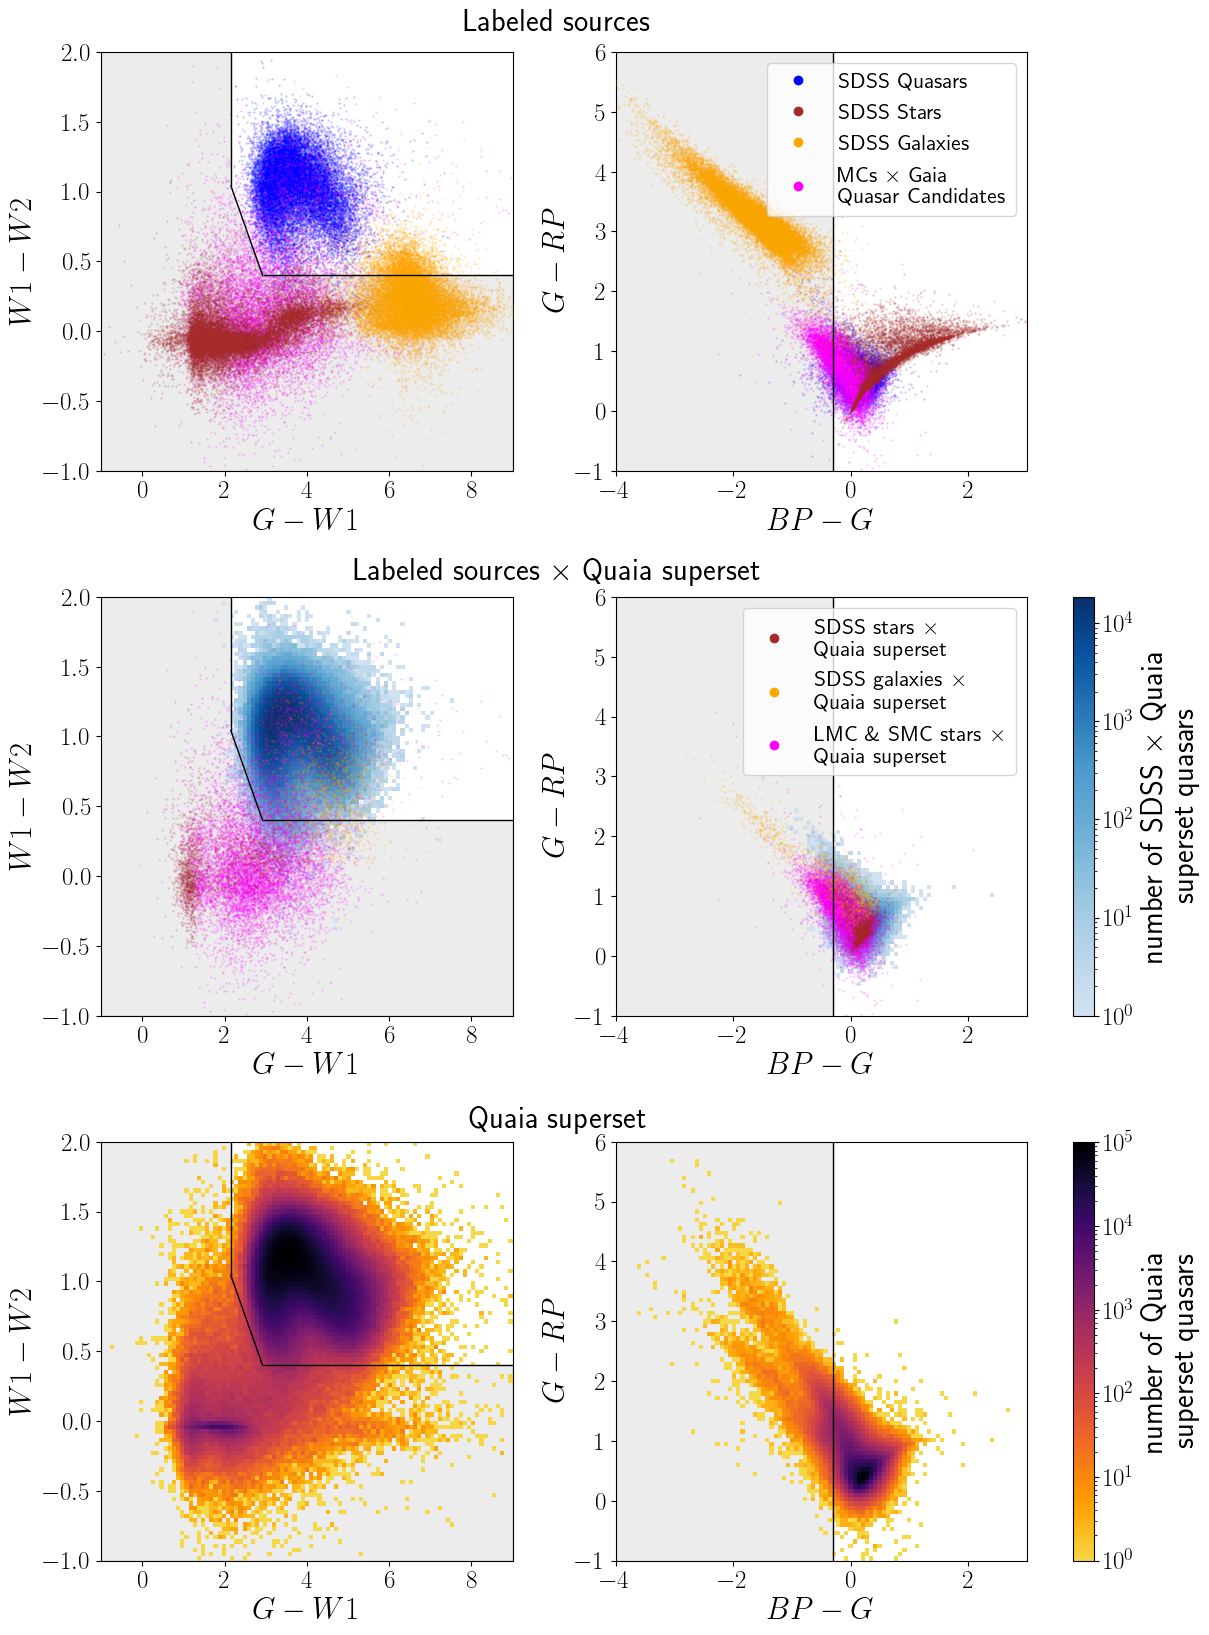

In [40]:
nrows = 3
fig, axarr = plt.subplots(nrows=nrows, ncols=2, figsize=(12,5.3*nrows), constrained_layout=True)
title_x = 0.46
fig.text(title_x, 1.01, "Labeled sources", fontsize=22, va="center", ha="center")
fig.text(title_x, 0.665, rf"Labeled sources $\times$ {abbrv_catalog} superset", fontsize=22, va="center", ha="center")
fig.text(title_x, 0.32, abbrv_catalog+' superset', fontsize=22, va="center", ha="center")

color_color_plot_row(axarr[0,0], axarr[0,1], fig, tabs_scatter=tabs_sall, colors_scatter=colors_sall, 
                     labels_scatter=labels_sall, zorders_scatter=zorders_sall, N_subsample=20000)
color_color_plot_row(axarr[1,0], axarr[1,1], fig, tabs_scatter=tabs_ssup, colors_scatter=colors_ssup, 
                     labels_scatter=labels_ssup, zorders_scatter=zorders_ssup,
                     tab_hist=tab_q, cmap_hist=cmap_blues, label_hist=label_shist, cmax_hist=5e4)
color_color_plot_row(axarr[2,0], axarr[2,1], fig,
                     tab_hist=tab_gsup, cmap_hist=cmap_hist, label_hist=label_ghist, cmax_hist=2e5)
fig.get_layout_engine().set(hspace=0.1, wspace=0.05)

fn = f'{plot_dir}/color_color.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

## Redshift analysis vs SDSS

In [41]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 243206
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


In [42]:
rand_ints_labeled = tab_spz_labeled['rand_ints']
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints_labeled,
                                 frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [43]:
idx_Glo_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_lo

In [44]:
idx_Ghi_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_hi

### Redshift estimates vs SDSS accuracy

In [45]:
z_sdss_test = tab_spz_labeled['z_sdss'][i_test]
z_spzraw_test = tab_spz_labeled['redshift_spz_raw'][i_test]
z_spz_test = tab_spz_labeled['redshift_spz'][i_test]
z_gaia_test = tab_spz_labeled['redshift_qsoc'][i_test]

In [46]:
dz_spzraw_test = (z_spzraw_test - z_sdss_test)/(1+z_sdss_test)
dz_spz_test = (z_spz_test - z_sdss_test)/(1+z_sdss_test)
dz_gaia_test = (z_gaia_test - z_sdss_test)/(1+z_sdss_test)

In [47]:
z_bins = np.linspace(0, np.max(z_gaia_test), 200)

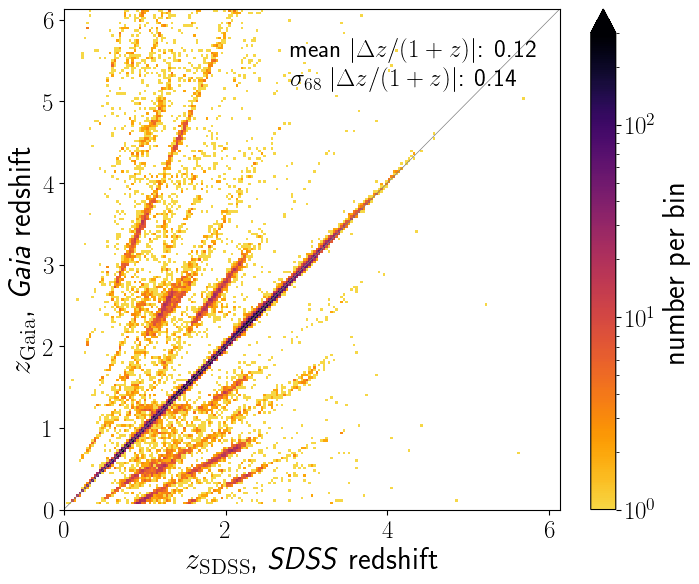

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))

h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_gaia_test[idx_Ghi_test], bins=z_bins, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmin=1, vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin', extend='max')
plt.plot(z_bins, z_bins, color='grey', lw=0.5)

# text
mean = np.mean(dz_gaia_test)
p16 = np.percentile(dz_gaia_test, 16)
p84 = np.percentile(dz_gaia_test, 84)
sigma = 0.5*(p84-p16)
text = rf'mean $|\Delta z/(1+z)|$: {mean:.2f}' + '\n' + \
       rf'$\sigma_{{68}}$ $|\Delta z/(1+z)|$: {sigma:.2f} '
plt.text(2.8, 5.2, text, fontsize=18)

plt.xlabel(rf'${abbrv_zsdss}$, {name_zsdss}')
plt.ylabel(rf'${abbrv_zgaia}$, {name_zgaia}')

fn = f'{plot_dir}/redshift_zgaia_vs_zsdss_Ghi.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

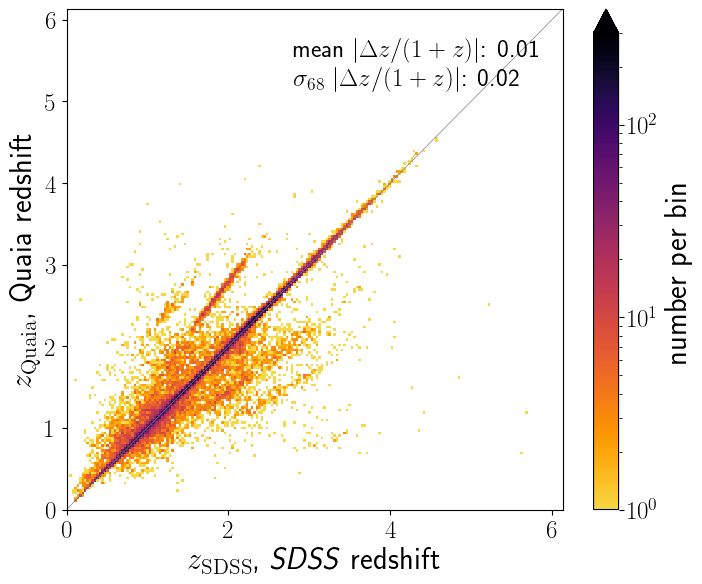

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_spz_test[idx_Ghi_test], bins=z_bins, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmin=1, vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin', extend='max')

plt.plot(z_bins, z_bins, color='grey', lw=0.5)

# text
mean = np.mean(dz_spz_test)
p16 = np.percentile(dz_spz_test, 16)
p84 = np.percentile(dz_spz_test, 84)
sigma = 0.5*(p84-p16)
text = rf'mean $|\Delta z/(1+z)|$: {mean:.2f}' + '\n' + \
       rf'$\sigma_{{68}}$ $|\Delta z/(1+z)|$: {sigma:.2f} '
plt.text(2.8, 5.2, text, fontsize=18)

plt.xlabel(rf'${abbrv_zsdss}$, {name_zsdss}')
plt.ylabel(rf'${abbrv_zspz}$, {name_zspz}')

fn = f'{plot_dir}/redshift_zspz_vs_zsdss_Ghi.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### dz error cumulative histograms

In [50]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

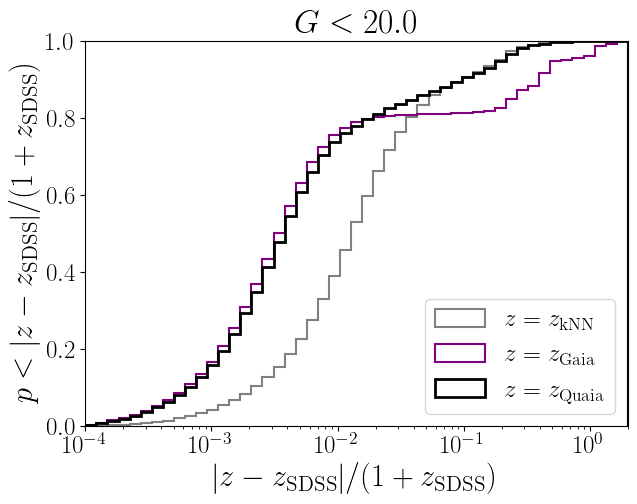

In [51]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_lo}$', fontsize=24)
lw=1.5
plt.hist(abs(dz_spzraw_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='grey', label=r'$z=z_\mathrm{kNN}$')
plt.hist(abs(dz_gaia_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color=color_gaia, label=rf'$z={abbrv_zgaia}$')
plt.hist(abs(dz_spz_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2,
         color='k', label=rf'$z={abbrv_zspz}$')
plt.xlabel(rf'$|z-{abbrv_zsdss}|/(1+{abbrv_zsdss})$')
plt.ylabel(rf'$p < |z-{abbrv_zsdss}|/(1+{abbrv_zsdss})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

fn = f'{plot_dir}/redshift_error_cumulative_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Fraction of outliers as function of G

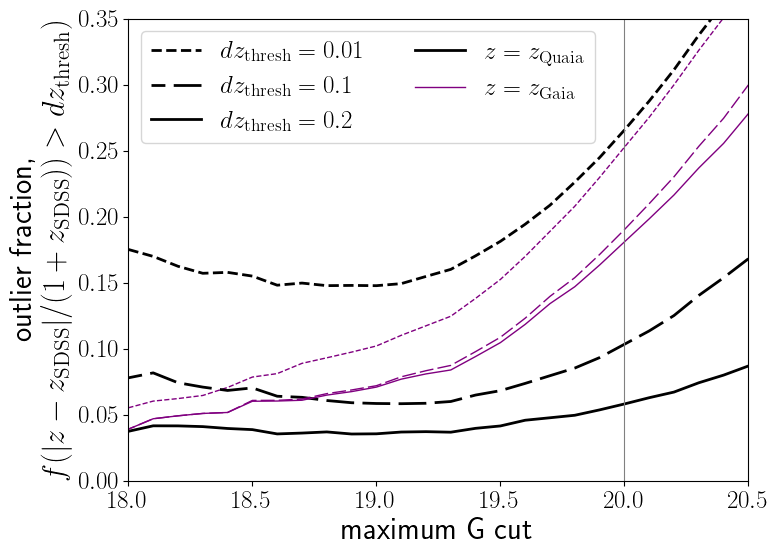

In [52]:
plt.figure(figsize=(8,6))
ax = plt.gca()

G_arr = tab_spz_labeled['phot_g_mean_mag'][i_test]
G_maxs = np.arange(18.0, 20.501, 0.1)

dz_threshs = [0.01, 0.1, 0.2]
alphas = [0.4, 0.6, 0.8, 1]
lss = ['--', (5, (10,3)), '-']
for iz, dz_thresh in enumerate(dz_threshs):
    n_insample = np.empty(len(G_maxs), dtype=int)
    f_outliers_spz = np.empty(len(G_maxs))
    f_outliers_gaia = np.empty(len(G_maxs))

    for i in range(len(G_maxs)):
        i_insample = G_arr < G_maxs[i]
        n_insample[i] = np.sum(i_insample)
        
        f_outliers_spz[i] = np.sum(np.abs(dz_spz_test[i_insample]) > dz_thresh) / n_insample[i]
        f_outliers_gaia[i] = np.sum(np.abs(dz_gaia_test[i_insample]) > dz_thresh) / n_insample[i]
        
    plt.plot(G_maxs, f_outliers_spz, color='k', alpha=1, ls=lss[iz], lw=2, label=fr'$dz_\mathrm{{thresh}}={dz_thresh}$')
    plt.plot(G_maxs, f_outliers_gaia, color=color_gaia, alpha=1, ls=lss[iz], lw=1)

plt.xlabel("maximum G cut")
plt.ylabel('outlier fraction,\n' + rf'$f(|z-{abbrv_zsdss}|/(1+{abbrv_zsdss}))>dz_\mathrm{{thresh}})$')
plt.ylim(0, 0.35)
plt.xlim(np.min(G_maxs), np.max(G_maxs))


handles, labels = ax.get_legend_handles_labels()
line_spz = Line2D([], [], color='k', lw=2)
line_gaia = Line2D([], [], color=color_gaia, lw=1)
handles.extend([line_spz, line_gaia])
labels.extend([f'$z={abbrv_zspz}$', f'$z={abbrv_zgaia}$'])

plt.legend(handles, labels, ncol=2)

plt.axvline(20.0, color='grey', lw=0.8)

fn = f'{plot_dir}/redshift_outliers_vs_Gmax.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Selection function systematics maps

In [53]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(NSIDE, NPIX)
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

64 49152
Area per pixel: 0.839 deg


In [54]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
map_dust = maps.get_dust_map(NSIDE=NSIDE, R=3.1, fn_map=fn_dustmap)

Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy


In [55]:
fn_starmap = f'../data/maps/map_stars_NSIDE{NSIDE}.npy'
map_stars = maps.get_star_map(NSIDE=NSIDE, fn_map=fn_starmap)
map_stardens = map_stars/area_per_pixel

Star map already exists, loading from ../data/maps/map_stars_NSIDE64.npy


In [56]:
fn_m10map = f'../data/maps/map_m10_NSIDE{NSIDE}.npy'
map_m10 = maps.get_m10_map(NSIDE=NSIDE, fn_map=fn_m10map)

M10 map already exists, loading from ../data/maps/map_m10_NSIDE64.npy


In [57]:
fn_mcsmap = f'../data/maps/map_mcs_NSIDE{NSIDE}.npy'
map_mcs = maps.get_mcs_map(NSIDE, fn_map=fn_mcsmap)

MCs map already exists, loading from ../data/maps/map_mcs_NSIDE64.npy


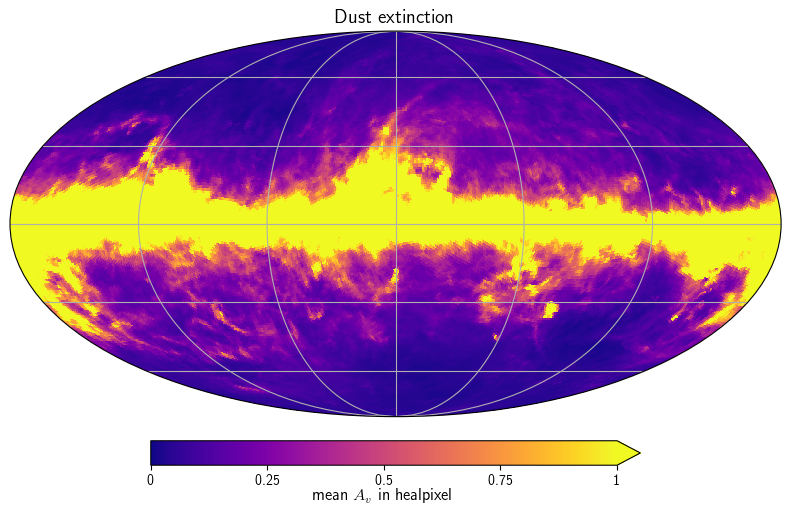

In [58]:
projview(map_dust, title=rf"Dust extinction",
         unit=r"mean $A_v$ in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=0.0, max=1.0, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
         graticule=True)

fn = f'{plot_dir}/systematics_map_dust.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

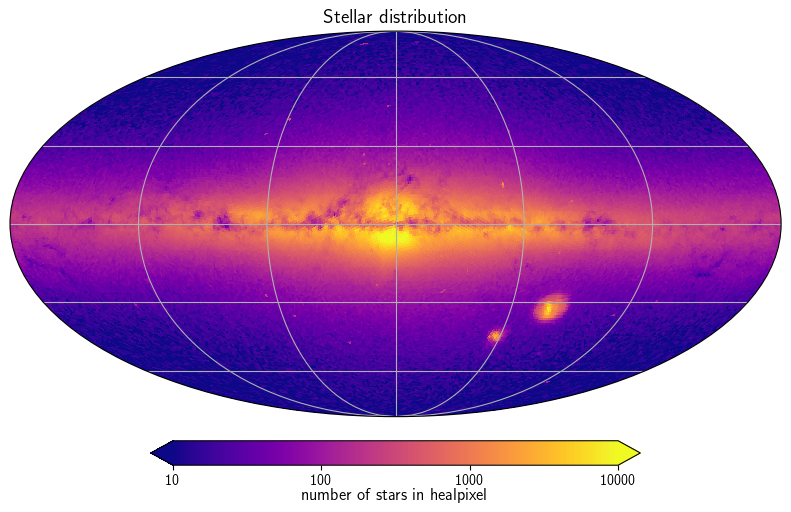

In [59]:
projview(map_stars, title=rf"Stellar distribution",
         unit=r"number of stars in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=10000, norm='log', cbar_ticks=[10, 100, 1000, 10000],
         graticule=True)

fn = f'{plot_dir}/systematics_map_stars.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

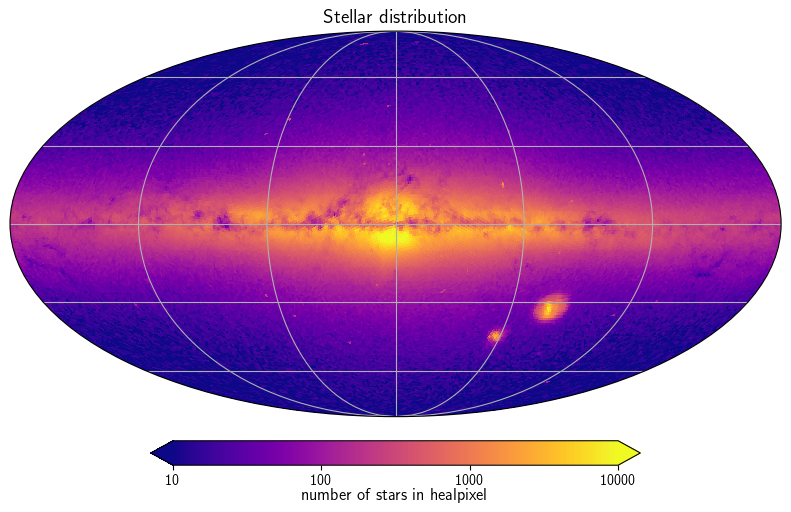

In [60]:
projview(map_stars, title=rf"Stellar distribution",
         unit=r"number of stars in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=10000, norm='log', cbar_ticks=[10, 100, 1000, 10000],
         graticule=True)

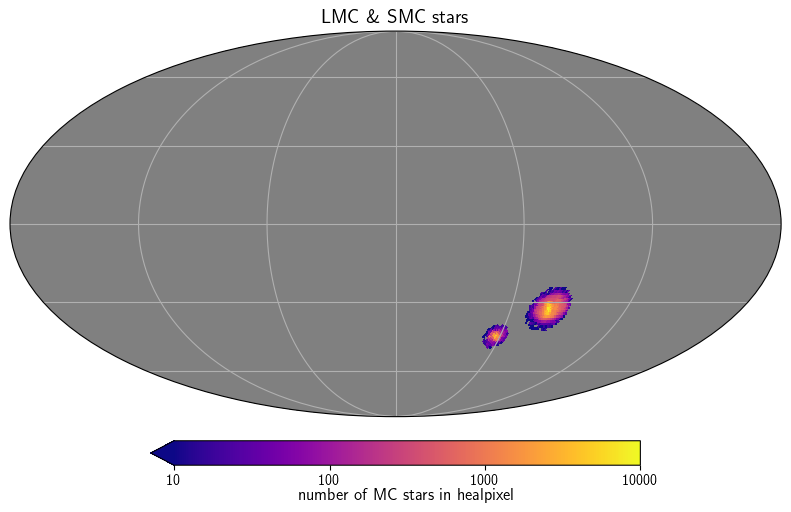

In [61]:
projview(map_mcs, title=rf"LMC \& SMC stars",
         unit=r"number of MC stars in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         #min=-1, max=1,
         min=10, max=10000, norm='log', cbar_ticks=[10, 100, 1000, 10000],
         graticule=True)

fn = f'{plot_dir}/systematics_map_mcs.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

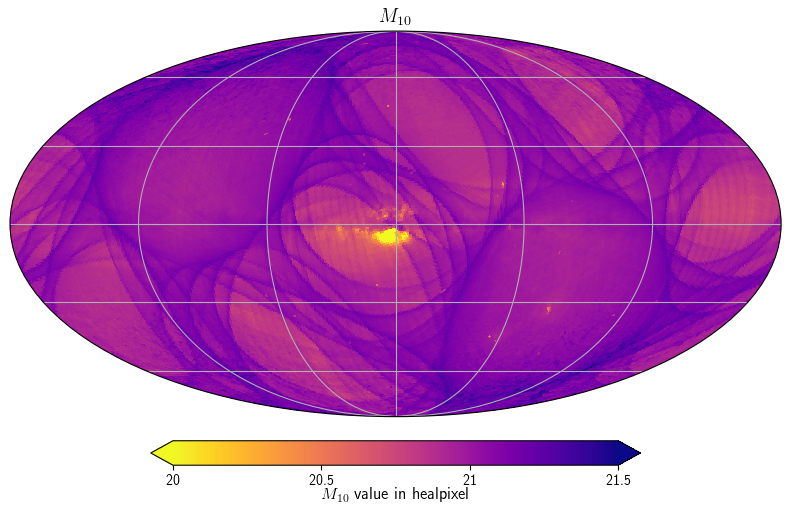

In [62]:
# reverse colormap bc high is worse here
projview(map_m10, title=r"$M_{10}$",
         unit=r"$M_{10}$ value in healpixel", cmap=cmap_map+'_r', coord=['C', 'G'],
         min=20.0, max=21.5, cbar_ticks=[20.0, 20.5, 21.0, 21.5],
         graticule=True)

fn = f'{plot_dir}/systematics_map_m10.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Catalog properties

### Sky distribution

In [63]:
map_gcatlo = get_ndens_map(tab_gcatlo['ra'], tab_gcatlo['dec'])

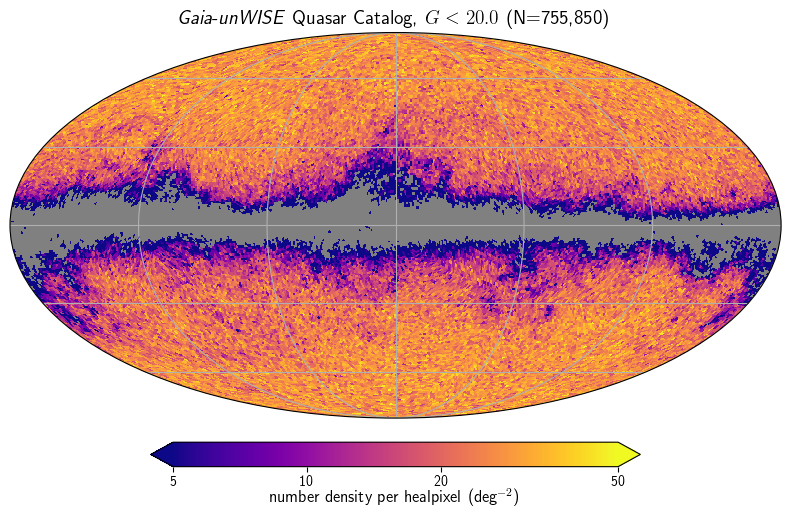

In [64]:
title_gcatlo = rf"{name_catalog}, $G<{G_lo}$ (N={len(tab_gcatlo):,})"
projview(map_gcatlo, title=title_gcatlo,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=50, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50])

fn = f'{plot_dir}/gcatlo_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [65]:
map_gcathi = get_ndens_map(tab_gcathi['ra'], tab_gcathi['dec'])

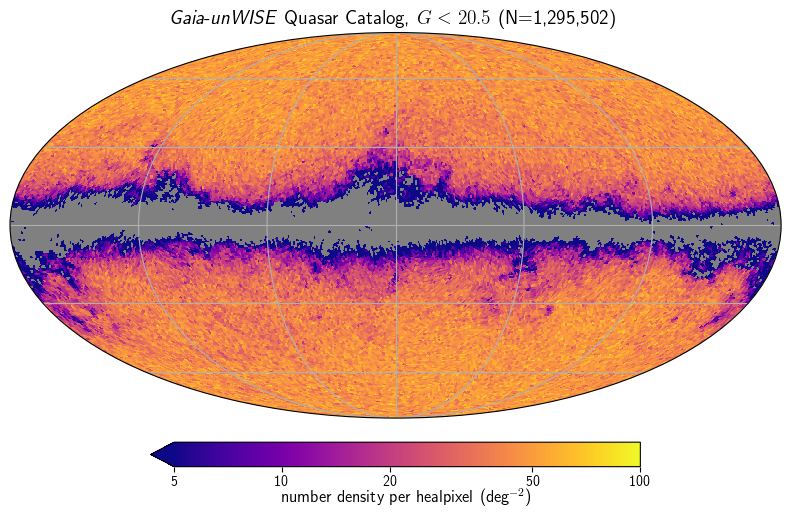

In [66]:
title_gcathi = rf"{name_catalog}, $G<{G_hi}$ (N={len(tab_gcathi):,})"
projview(map_gcathi, title=title_gcathi,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=100, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100])

fn = f'{plot_dir}/gcathi_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Redshift distribution

/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


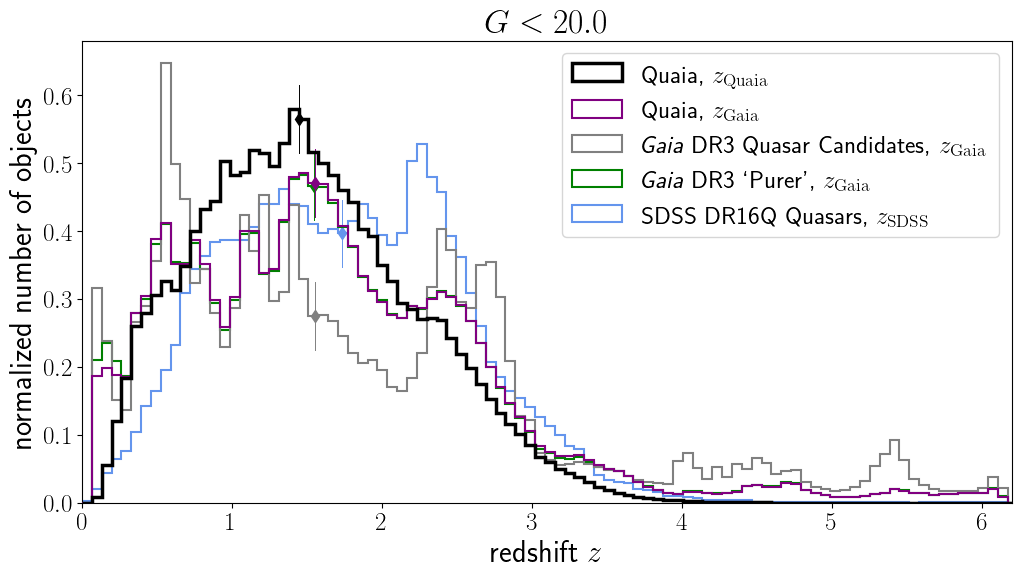

In [67]:
alpha = 1
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

tabs_znames = [(tab_gcathi, 'redshift_spz'),
              (tab_gcathi, 'redshift_qsoc'),
              (tab_gall, 'redshift_qsoc'),
              (tab_gpurer, 'redshift_qsoc'),
              (tab_sqall, 'z_sdss')
             ]

labels = [abbrv_catalog+rf', ${abbrv_zspz}$',
          abbrv_catalog+rf', ${abbrv_zgaia}$',
          abbrv_gall+rf', ${abbrv_zgaia}$',
          abbrv_gpurer+rf', ${abbrv_zgaia}$',
          abbrv_sqall+rf', ${abbrv_zsdss}$'
         ]

colors = ['black', color_gaia, 'grey', 'green', 'cornflowerblue']
#lws = [2, 1, 1, 1, 1]
lws = [2.5, 1.5, 1.5, 1.5, 1.5]
zorders = [5,4,3,2,1]

plt.figure(figsize=(12,6))
plt.title(rf"$G < {G_lo}$")

lw_med = 0.7
for ii in range(len(tabs_znames)):
    tab, z_name = tabs_znames[ii]
    i_G = tab['phot_g_mean_mag'] < G_lo

    z_data = tab[i_G][z_name]
    i_finite = np.isfinite(z_data)
    z_data = z_data[i_finite]

    ns, bs, _ = plt.hist(z_data, bins=z_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii], zorder=zorders[ii])
    
    z_med = np.median(z_data)
    # figure out where to plot median
    bb = np.digitize(z_med, bs)
    nval = ns[bb-1]
    plt.plot([z_med]*2, [nval-0.05, nval+0.05], lw=lw_med, color=colors[ii], zorder=zorders[ii])
    plt.plot(z_med, nval, marker='d', color=colors[ii], zorder=zorders[ii])
    #print(f'{z_med:.3f}')

plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

plt.xlim(0,6.2)

fn = f'{plot_dir}/redshift_dists_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### G distribution

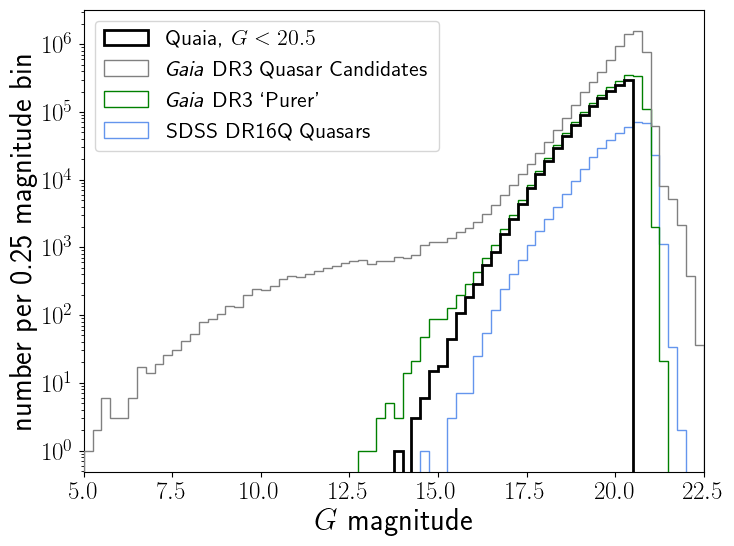

In [68]:
xlim = 5, 22.5
bin_width = 0.25
G_bins = np.arange(xlim[0], xlim[1]+bin_width, bin_width)

alpha = 1
density = False
histtype='step'

tabs = [tab_gcathi,
        tab_gall,
        tab_gpurer,
        tab_sqall,
        ]

labels = [rf'{abbrv_catalog}, $G<{G_hi}$',
          abbrv_gall,
          abbrv_gpurer,
          abbrv_sqall
         ]

colors = ['black', 'grey', 'green', 'cornflowerblue']
lws = [2, 1, 1, 1, 1]
zorders = [5,4,3,2,1]

plt.figure(figsize=(8,6))

lw_med = 0.7
for ii in range(len(tabs)):
    G_data = tabs[ii]['phot_g_mean_mag'] 
    i_finite = np.isfinite(G_data)
    G_data = G_data[i_finite]

    plt.hist(G_data, bins=G_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii], zorder=zorders[ii])
    
plt.yscale('log')
plt.xlabel(r'$G$ magnitude')
plt.ylabel(f'number per {bin_width} magnitude bin')
plt.legend(fontsize=16)

plt.xlim(xlim)

fn = f'{plot_dir}/G_dist.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Selection function map

In [69]:
fn_sel = f"../data/maps/selection_function_NSIDE{NSIDE}_G{G_lo}.fits"
map_sel = hp.read_map(fn_sel)

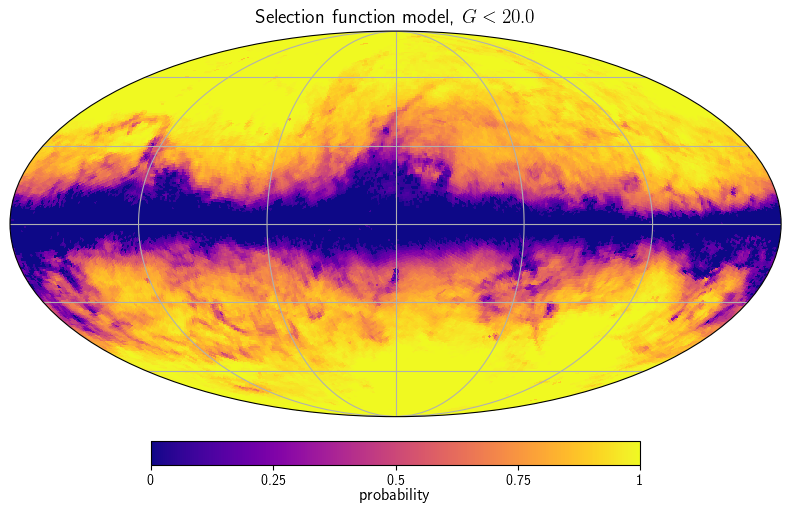

In [70]:
projview(map_sel, title=rf"Selection function model, $G<{G_lo}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True, min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
            ) 

fn = f'{plot_dir}/selection_function_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Random catalog & residuals

In [90]:
fn_rand_Glo = f'../data/randoms/random_G{G_lo}_10x.fits'
tab_rand_Glo = Table.read(fn_rand_Glo)
print(f"Number of random sources: {len(tab_rand_Glo)}")

Number of random sources: 7555779


In [91]:
map_rand_Glo = get_ndens_map(tab_rand_Glo['ra'], tab_rand_Glo['dec'])

Currently don't have random plot in the paper, just the residuals, but plot here as check

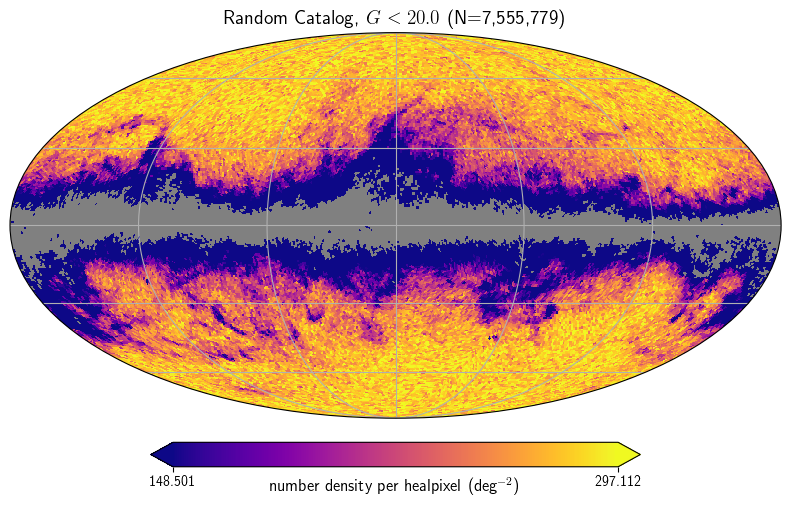

In [92]:
projview(map_rand_Glo, title=rf"Random Catalog, $G<{G_lo}$ (N={len(tab_rand_Glo):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=np.median(map_rand_Glo)-np.std(map_rand_Glo), max=np.median(map_rand_Glo)+np.std(map_rand_Glo), 
            norm='log', graticule=True,
            #show_tickmarkers=True
        )#, cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

In [93]:
norm_factor = len(tab_gcatlo)/len(tab_rand_Glo)
print(norm_factor)
map_residuals_Glo = norm_factor*map_rand_Glo/map_gcatlo - 1

0.10003601217028714


In [94]:
print(np.mean(norm_factor*map_rand_Glo), np.mean(map_gcatlo))
print('RMSE:', utils.compute_rmse(norm_factor*map_rand_Glo, map_gcatlo))
print('RMSE frac:', utils.compute_rmse(norm_factor*map_rand_Glo, map_gcatlo, fractional=True))

21.236558207886937 21.236558207886937
RMSE: 5.451382678967627
RMSE frac: 0.5095264835528696


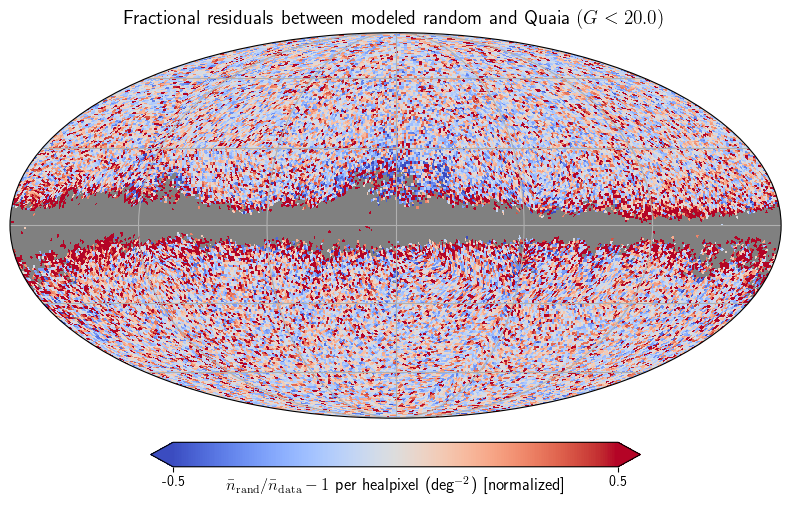

In [95]:
projview(map_residuals_Glo, title=rf"Fractional residuals between modeled random and {abbrv_catalog} $(G<{G_lo})$",
            unit=r"$\bar{n}_\mathrm{rand}/\bar{n}_\mathrm{data}-1$ per healpixel (deg$^{-2}$) [normalized]", 
          cmap='coolwarm', coord=['C', 'G'], 
            min=-0.5, max=0.5, 
            graticule=True
            #show_tickmarkers=True
            )#cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

fn = f'{plot_dir}/residuals_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Animation snapshot

In [77]:
lim = 3500
vmin, vmax = 0, 4.5

In [78]:
tab_gcathi_anim = animate.prepare_data(tab_gcathi, 'redshift_spz')

Converting to cartesian
Adding properties


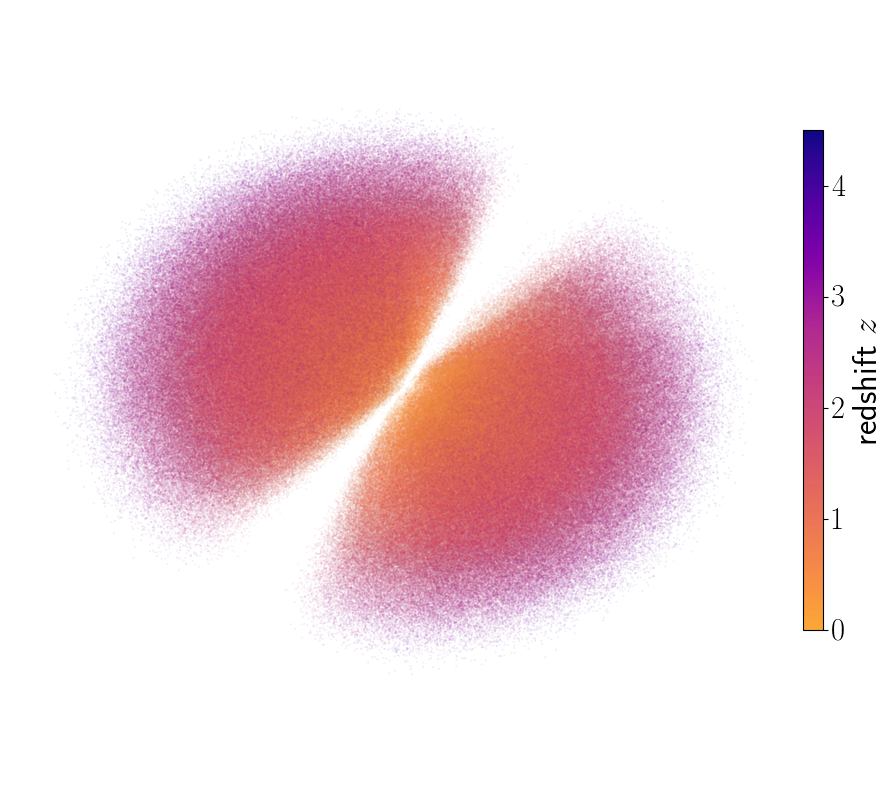

In [79]:
property_colorby = 'redshift_spz'

s = 0.11
alpha = 0.1
colorbar_label = r'redshift $z$'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
animate.init_animation(fig, ax, tab_gcathi_anim, tab_gcathi_anim[property_colorby], 
                       s, alpha, lim, vmin, vmax,
                       cmap=cmap_anim, colorbar_label=colorbar_label)

fn = f'{plot_dir}/gcathi_3d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

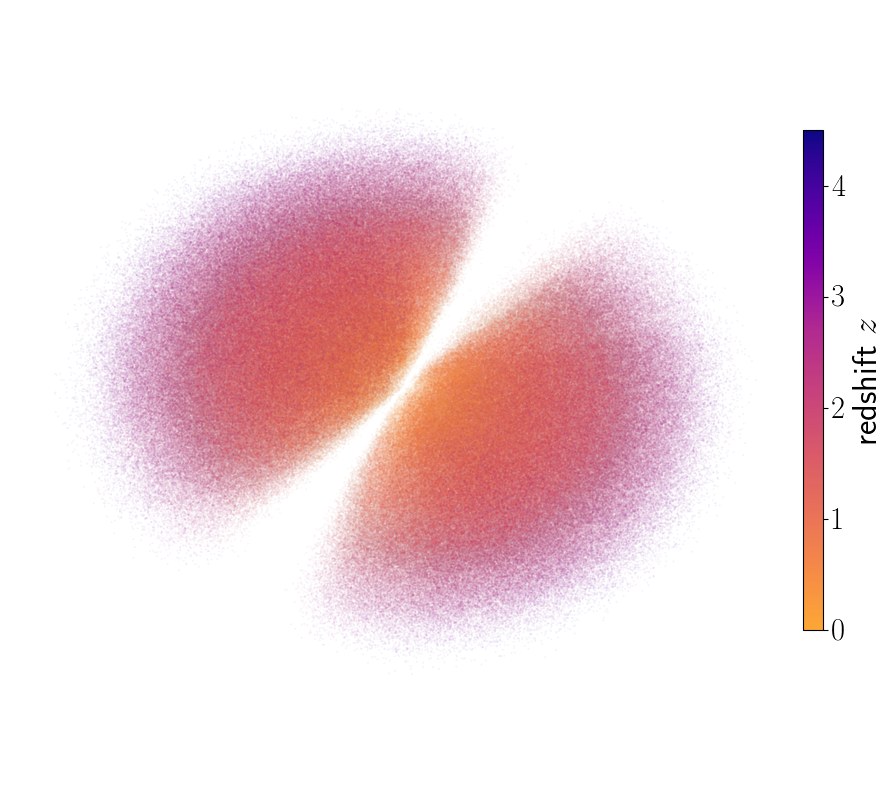

In [80]:
property_colorby = 'redshift_spz'

s = 0.1
#alpha = 0.1
alpha = 0.07
colorbar_label = r'redshift $z$'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
animate.init_animation(fig, ax, tab_gcathi_anim, tab_gcathi_anim[property_colorby], 
                       s, alpha, lim, vmin, vmax,
                       cmap=cmap_anim, colorbar_label=colorbar_label)

fn = f'{plot_dir}/gcathi_3d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [81]:
tab_sdss_anim = animate.prepare_data(tab_sqall, 'z_sdss', ra_name='ra_sdss', dec_name='dec_sdss')

Converting to cartesian
Adding properties


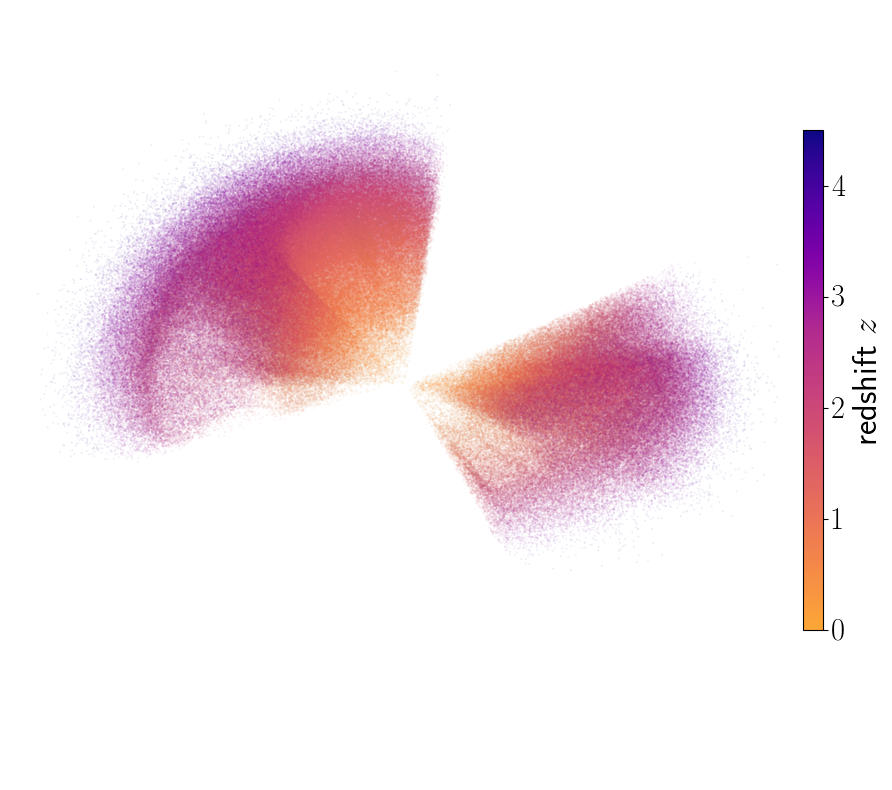

In [82]:
property_colorby = 'z_sdss'

s = 0.11
alpha = 0.1
colorbar_label = r'redshift $z$'

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
animate.init_animation(fig, ax, tab_sdss_anim, tab_sdss_anim[property_colorby], 
                       s, alpha, lim, vmin, vmax,
                       cmap=cmap_anim, colorbar_label=colorbar_label)

fn = f'{plot_dir}/sdss_3d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')